In [1]:
'''
Patrick Ballou
ID: 801130521
ECGR 4106
Homework 5
Problem 1
'''

'\nPatrick Ballou\nID: 801130521\nECGR 4106\nHomework 5\nProblem 1\n'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import cuda
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np
import time

In [3]:
#check if GPU is available and set the device accordingly
#device = 'torch.device("cuda:0" if torch.cuda.is_available() else "cpu")'
device = 'cuda'
print("Using GPU: ", cuda.get_device_name())

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Using GPU:  NVIDIA L4
Thu Apr 25 14:48:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   52C    P8              13W /  72W |      4MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+---

In [4]:
text = """Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it. This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text.

At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model.

One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character. LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks.

Training a model for next character prediction involves feeding it large amounts of text data, allowing it to learn the probability of each character's appearance following a sequence of characters. During this training process, the model adjusts its parameters to minimize the difference between its predictions and the actual outcomes, thus improving its predictive accuracy over time.

Once trained, the model can be used to predict the next character in a given piece of text by considering the sequence of characters that precede it. This can enhance user experience in text editing software, improve efficiency in coding environments with auto-completion features, and enable more natural interactions with AI-based chatbots and virtual assistants.

In summary, next character prediction plays a crucial role in enhancing the capabilities of various NLP applications, making text-based interactions more efficient, accurate, and human-like. Through the use of advanced machine learning models like RNNs and LSTMs, next character prediction continues to evolve, opening new possibilities for the future of text-based technology."""

In [5]:
# Creating character vocabulary
chars = sorted(list(set(text)))
ix_to_char = {i: ch for i, ch in enumerate(chars)}
char_to_ix = {ch: i for i, ch in enumerate(chars)}

In [6]:
def prepare_dataset(max_length):
    X = []
    y = []
    for i in range(len(text) - max_length):
        sequence = text[i:i + max_length]
        label = text[i + max_length]
        X.append([char_to_ix[char] for char in sequence])
        y.append(char_to_ix[label])

    X = np.array(X)
    y = np.array(y)

    # Splitting the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Converting data to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.long)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_val = torch.tensor(X_val, dtype=torch.long)
    y_val = torch.tensor(y_val, dtype=torch.long)

    return X_train, y_train, X_val, y_val

In [7]:
# Defining the Transformer model
class CharTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead):
        super(CharTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])  # Get the output of the last Transformer block
        return output

In [8]:
def training_loop(model, criterion, optimizer, epochs, X_train, y_train, X_val, y_val, max_length):

    train_history = []
    val_history = []
    init_time = time.time()
    print(f"{max_length} sequence transformer results:")

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val)
            _, predicted = torch.max(val_output, 1)
            val_accuracy = (predicted == y_val).float().mean()

        train_history.append(loss.item())
        val_history.append(val_accuracy.item())

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {train_history[-1]}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_history[-1]}')

    print(f"Training time: {time.time() - init_time} seconds")
    save_path = f'../../Models/hw5_1_{max_length}.pth'
    #torch.save(model.state_dict(), save_path)

    return train_history, val_history

# Prediction function
def predict_next_char(model, initial_str, max_length):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[int(predicted_index)]

def next_char_test(model, max_length):
    test_str = "This is a simple example to demonstrate how to predict the next char"
    predicted_char = predict_next_char(model, test_str, max_length)
    print(f"Predicted next character: '{predicted_char}'")

In [9]:
# Hyperparameters
hidden_size = 256
num_layers = 4
nhead = 4

max_lengths = [10, 20, 30]
learning_rate = .0005
epochs = 100

In [10]:
train_histories = []
val_histories = []

for window_size in max_lengths:
    model = CharTransformer(len(chars), hidden_size, len(chars), num_layers, nhead)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    X_train, y_train, X_val, y_val = prepare_dataset(window_size)

    train_history, val_history = training_loop(model, criterion, optimizer, epochs, X_train, y_train, X_val, y_val, window_size)
    train_histories.append(train_history)
    val_histories.append(val_history)
    print("\n")

    next_char_test(model, window_size)
    print("\n\n") if window_size != 30 else None

10 sequence transformer results:
Epoch 10, Loss: 2.4080586433410645, Validation Loss: 2.5051023960113525, Validation Accuracy: 0.2704402506351471
Epoch 20, Loss: 2.0444071292877197, Validation Loss: 2.4036715030670166, Validation Accuracy: 0.33752620220184326
Epoch 30, Loss: 1.6987130641937256, Validation Loss: 2.373068332672119, Validation Accuracy: 0.3668763041496277
Epoch 40, Loss: 1.3319175243377686, Validation Loss: 2.4580023288726807, Validation Accuracy: 0.3731656074523926
Epoch 50, Loss: 0.9410110116004944, Validation Loss: 2.65513277053833, Validation Accuracy: 0.36477985978126526
Epoch 60, Loss: 0.6164496541023254, Validation Loss: 2.9696104526519775, Validation Accuracy: 0.3542976975440979
Epoch 70, Loss: 0.4114442467689514, Validation Loss: 3.1755635738372803, Validation Accuracy: 0.3731656074523926
Epoch 80, Loss: 0.22664591670036316, Validation Loss: 3.445261240005493, Validation Accuracy: 0.3689727485179901
Epoch 90, Loss: 0.17504791915416718, Validation Loss: 3.69699287

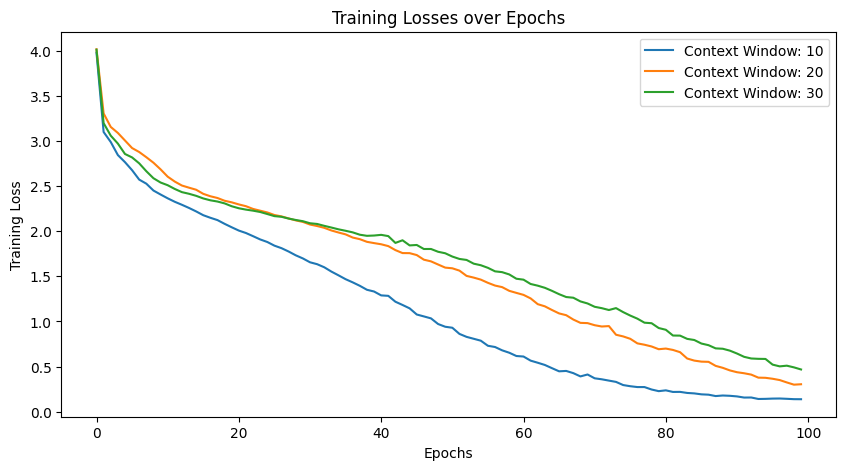

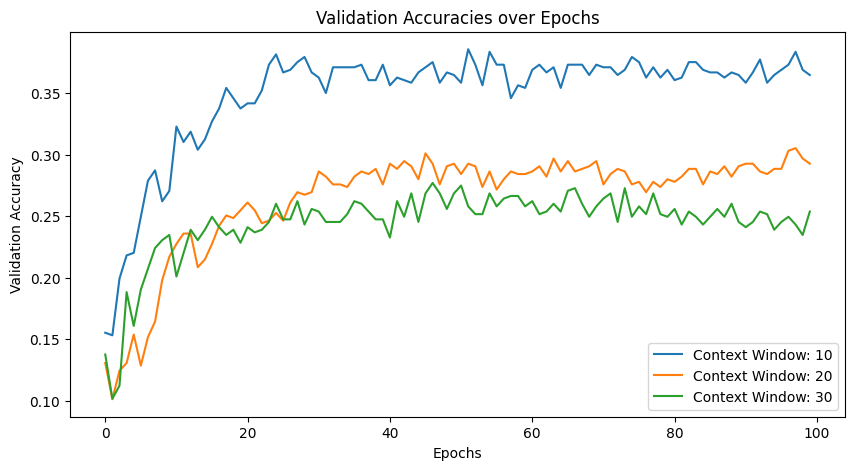

In [11]:
# Plotting training losses
plt.figure(figsize=(10, 5))
for i, max_length in enumerate(max_lengths):
    plt.plot(train_histories[i], label=f"Context Window: {max_length}")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Losses over Epochs")
plt.legend()
plt.show()

# Plotting validation accuracies
plt.figure(figsize=(10, 5))
for i, max_length in enumerate(max_lengths):
    plt.plot(val_histories[i], label=f"Context Window: {max_length}")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracies over Epochs")
plt.legend()
plt.show()